In [1]:
from pathlib import Path
import os
import sys
import shutil
import numpy as np
import time
import datetime
import numpy as np
import torch
import torch.nn as nn
import torchvision
import cfg
from torchvision.utils import save_image, make_grid

from types import SimpleNamespace

from models.ResNet import Res12_Quadratic, Res18_Quadratic
from functions.sampling import Langevin_E, SS_denoise,  Annealed_Langevin_E,Reverse_AIS_sampling,AIS_sampling
from functions.analysis import save_sample_pdf

In [2]:
args = SimpleNamespace()
args.n_samples_save = 30000
args.batch_size = 1024
args.n_chan = 64
args.n_gpus = 1
args.max_lr = 1e-4
args.min_noise = 0.1
args.max_noise = 3
args.noise_distribution = 'exp'
args.save_every = 5000

args.dataset = 'fmnist'
args.log = 'fmnist_EBM'
args.lr_schedule = 'cosine'
args.rand_seed = 42
args.cont = False
args.net_indx = 2000

args.annealing_schedule = 'exp'
args.sample_mode = 'all'
args.time = '2024_Apr28_12_10'
args.file_name = 'mdsm_ebm' 
args.sample_step_size = 0.01

In [3]:
torch.cuda.empty_cache()
torch.cuda.manual_seed(args.rand_seed)

if args.dataset == 'cifar':
    sample_x = torch.zeros((args.batch_size,3,32,32))
    #netE = Res18_Quadratic(3,args.n_chan,32,normalize=False,AF=nn.ELU())
    netE = SE_Res18_Quadratic(3,args.n_chan,32,normalize=False,AF=Swish())

elif args.dataset == 'mnist':
    sample_x = torch.zeros((args.batch_size,1,32,32))
    netE = Res12_Quadratic(1,args.n_chan,32,normalize=False,AF=nn.ELU())

elif args.dataset == 'fmnist':
    sample_x = torch.zeros((args.batch_size,1,32,32))
    netE = Res12_Quadratic(1,args.n_chan,32,normalize=False,AF=nn.ELU())

else:
    NotImplementedError('{} unknown dataset'.format(args.dataset))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netE = netE.to(device)
if args.n_gpus >1:
    netE = nn.DataParallel(netE)

root = 'logs/' + args.log + '_'+ args.time

In [5]:
if args.annealing_schedule =='exp':
    Nsampling = 2000 #exponential schedule with flat region in the beginning and end
    Tmax,Tmin = 100,1
    T = Tmax*np.exp(-np.linspace(0,Nsampling-1,Nsampling)*(np.log(Tmax/Tmin)/Nsampling))
    T = np.concatenate((Tmax*np.ones((500,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,200)),axis=0)

elif args.annealing_schedule == 'lin':
    Nsampling = 500 #linear schedule with flat region in the beginning and end
    Tmax,Tmin = 100,1
    T = np.linspace(Tmax,Tmin,Nsampling)
    T = np.concatenate((Tmax*np.ones((500,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,200)),axis=0)

In [6]:
if args.sample_mode == 'single':
    filename = args.file_name + str(args.net_indx) + '.pt'
    netE.load_state_dict(torch.load(root + '/models/'+filename))

    n_batches = int(np.ceil(args.n_samples_save/args.batch_size))

    denoise_samples = []
    print('sampling starts')
    for i in range(n_batches):
        initial_x = 0.5+torch.randn_like(sample_x).to(device)
        x_list,E_trace = Annealed_Langevin_E(netE,initial_x,args.sample_step_size,T,100)

        x_denoise = SS_denoise(x_list[-1][:].to(device),netE,0.1)
        denoise_samples.append(x_denoise)
        print('batch {}/{} finished'.format((i+1),n_batches))

    denoise_samples = torch.cat(denoise_samples,0)
    torch.save(denoise_samples,root + '/samples/' + args.dataset+'_'+str(args.n_samples_save)+'samples.pt')


elif args.sample_mode == 'all':
    n_batches = int(np.ceil(256/args.batch_size))
    i = args.net_indx
    while True:
        filename = args.file_name + str(i) + '.pt'
        i += args.save_every
        try:
            netE.load_state_dict(torch.load(root + '/models/'+filename))
        except:
            print(root + '/models/'+filename)
            print('file not found or reached last file')
            break

        print('generating samples for '+ filename)
        denoise_samples = []
        for j in range(n_batches):
            initial_x = 0.5+torch.randn_like(sample_x).to(device)
            x_list,E_trace = Annealed_Langevin_E(netE,initial_x,args.sample_step_size,T,100)
            print(str(len(x_list)))
            x_denoise = SS_denoise(x_list[-1].to(device),netE,0.0) # 0.1
            denoise_samples.append(x_denoise)
            print('batch {}/{} finished'.format((j+1),n_batches))
        denoise_samples = torch.cat(denoise_samples,0)
        save_sample_pdf(denoise_samples[0:256],(16,16),root + '/samples/' + args.dataset +'_256samples_'+str(i)+'knet_denoise.pdf')

generating samples for mdsm_ebm2000.pt
langevin step 100
langevin step 200
langevin step 300
langevin step 400
langevin step 500
langevin step 600
langevin step 700
langevin step 800
langevin step 900
langevin step 1000
langevin step 1100
langevin step 1200
langevin step 1300
langevin step 1400
langevin step 1500
langevin step 1600
langevin step 1700
langevin step 1800
langevin step 1900
langevin step 2000
langevin step 2100
langevin step 2200
langevin step 2300
langevin step 2400
langevin step 2500
langevin step 2600
langevin step 2700
27
batch 1/1 finished
logs/fmnist_EBM_2024_Apr28_12_10/models/mdsm_ebm7000.pt
file not found or reached last file


<Figure size 546x546 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plot_sample(samples,grid_size,pad=2):
    #samples should be a torch tensor
    [Nsamples,Nchannels,Size_x,Size_y] = samples.shape
    
    
    last_step_denoise = make_grid(samples,normalize=False,nrow=grid_size[1],padding=pad).detach().cpu().numpy()
    last_step_denoise = np.moveaxis(last_step_denoise,0,2)
    
    n = colors.Normalize(vmin=0,vmax=1,clip=True)
    normalized=n(last_step_denoise)
    n_pix_column = grid_size[0]*Size_y + (grid_size[0]+1)*pad
    n_pix_row = grid_size[1]*Size_x + (grid_size[1]+1)*pad
    plt.figure(figsize=(n_pix_row/100*2,n_pix_column/100*2), dpi=100)
    plt.imshow(normalized, vmin=0, vmax=1)
    plt.show()

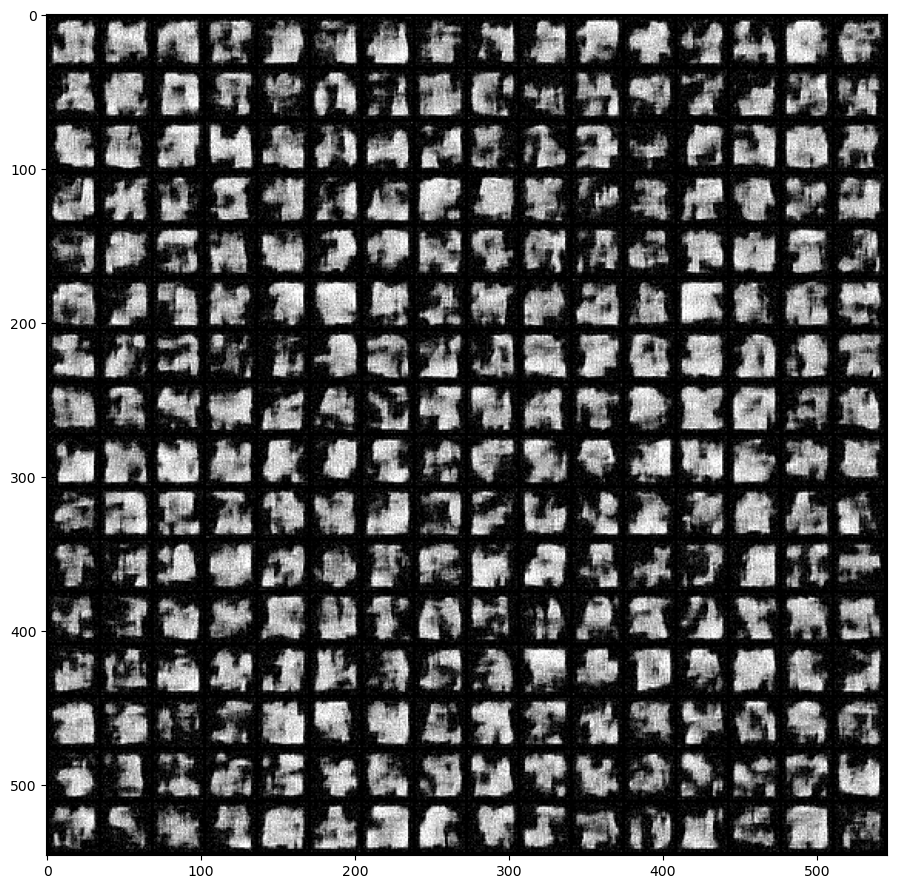

In [8]:
plot_sample(denoise_samples[0:256],(16,16))